# GPA
Generalized Procrustes analysis

In [1]:
import torch


def center_shape(x):
    """Removes translation by shifting the shape so that its centroid is at (0, 0)."""
    return x - x.mean(dim=0, keepdim=True)


def normalize_shape(x):
    """Scales the shape so that it has unit length (normalizes its size)."""
    return x / torch.norm(x)


def procrustes_align(x, y):
    """
    Aligns shape X to shape Y by rotation (Procrustes alignment).
    Assumes both shapes are already centered and normalized.
    """
    # Orthogonal rotation matrix `r` computed via SVD
    u, _, vt = torch.linalg.svd(x.T @ y)
    r = u @ vt
    return x @ r


def generalized_procrustes_analysis(shapes, tol=1e-6, max_iter=100, device=torch.device('cpu')):
    """
    Performs Generalized Procrustes Analysis (GPA) on a set of 2D shapes.

    Args:
        shapes (torch.Tensor): Tensor of shape (N, n_points, 2) containing N shapes.
        tol (float): Convergence tolerance for mean shape updates.
        max_iter (int): Maximum number of iterations allowed.
        device (torch.device): Device on which to perform computations.

    Returns:
        aligned (torch.Tensor): Tensor of aligned shapes of shape (N, n_points, 2).
        mean_shape (torch.Tensor): The resulting mean shape of shape (n_points, 2).
    """
    shapes = shapes.to(device, dtype=torch.float32)

    # Centering and normalization
    shapes = torch.stack([normalize_shape(center_shape(s)) for s in shapes])

    # Initialize mean shape
    mean_shape = normalize_shape(shapes.mean(dim=0))

    for i in range(max_iter):
        aligned = []
        for s in shapes:
            aligned.append(procrustes_align(s, mean_shape))
        aligned = torch.stack(aligned)

        new_mean = normalize_shape(aligned.mean(dim=0))
        diff = torch.norm(mean_shape - new_mean)
        mean_shape = new_mean

        print(f"Iteration {i} diff: {diff}")

        if diff < tol:
            print(f"Convergence reached after {i + 1} iterations.")
            break

    return aligned, mean_shape




# Dataset

In [8]:
import torch

from wings.config import PROCESSED_DATA_DIR

countries = ['AT', 'GR', 'HR', 'HU', 'MD', 'PL', 'RO', 'SI']
train_dataset = torch.load(
    PROCESSED_DATA_DIR / "mask_datasets" / 'rectangle' / "train_mask_dataset.pth",
    weights_only=False
)
max_n = len(train_dataset)
print(max_n)
_, _, orig_labels, _ = train_dataset[0]
print(orig_labels.shape)


15206
torch.Size([38])


# Using Dataset with GPA

## Create train coordinates array

In [5]:
from tqdm import tqdm
from torch.utils.data import DataLoader

loader = DataLoader(train_dataset, batch_size=64, num_workers=8)
orig_coords_list = []
for _, _, labels, _ in tqdm(loader, desc="Loading orig_labels", unit="batch"):
    orig_coords_list.append(labels.view(labels.size(0), -1, 2))  # we make shape (19, 2) from shape (38)
orig_coords = torch.cat(orig_coords_list)

print(orig_coords.shape)

aligned_coords, mean_coords = generalized_procrustes_analysis(orig_coords)
print(mean_coords.shape)


Loading orig_labels: 100%|██████████| 238/238 [00:45<00:00,  5.26batch/s]


torch.Size([15206, 19, 2])
Iteration 0 diff: 0.0001964124385267496
Iteration 1 diff: 7.297820303620028e-08
Convergence reached after 2 iterations.
torch.Size([19, 2])


## Permute coordinates

In [27]:
from scipy.spatial.distance import cdist
import torch
import numpy as np
from scipy.optimize import linear_sum_assignment


def center(x):
    return x - x.mean(dim=0, keepdim=True)


def normalize_by_fro(x):
    # Frobenius norm of matrix (n_points, 2)
    return x / torch.norm(x)


def orthogonal_procrustes(a, b):
    """
    Zakładamy A,b: (n_points, 2), centra = 0, opcjonalnie znormalizowane.
    Zwraca macierz rotacji R (2x2) minimalizującą ||A R - b||_F.
    """
    # A^T b -> (2,2)
    m = a.T @ b
    u, s, vt = torch.linalg.svd(m)
    r = u @ vt
    # poprawienie determinanty (zwykle det(R)=+1). Jeśli det=-1, korekta.
    if torch.det(r) < 0:
        # flip last column of U
        u[:, -1] *= -1
        r = u @ vt
    return r


def solve_assignment(cost_matrix):
    """
    cost_matrix: numpy array (n_mean, n_shape)
    zwraca permutację idx: array length n_mean, idx[j] = index in shape matched to mean j
    """
    r, c = linear_sum_assignment(cost_matrix)
    # r are row indices (0..n-1), c are matched col indices
    # want array idx where idx[row]=col
    idx = np.empty(cost_matrix.shape[0], dtype=int)
    idx[r] = c
    return idx


def recover_order(mean_shape, unordered_shape, max_iter=5, device=torch.device('cpu')):
    """
    mean_shape: torch tensor (n_points, 2)
    unordered_shape: torch tensor (n_points, 2) - same points but random order/transform
    Returns:
        perm_idx: numpy array length n_points such that mean_shape[i] corresponds to unordered_shape[perm_idx[i]]
        reordered_shape: torch tensor (n_points, 2) = unordered_shape[perm_idx]
        diagnostics: dict with final cost, iterations, converged flag
    """
    if device is None:
        device = mean_shape.device
    mean = mean_shape.to(device).float()
    S = unordered_shape.to(device).float()

    n = mean.shape[0]
    assert S.shape[0] == n and mean.shape[1] == 2

    # center both
    mean_c = center(mean)
    S_c = center(S)

    # optional normalize (helps numeric stability)
    mean_norm = normalize_by_fro(mean_c)
    S_norm = normalize_by_fro(S_c)

    # initial assignment: nearest neighbour in Euclidean space (no rotation)
    mm = mean_norm.cpu().numpy()
    ss = S_norm.cpu().numpy()

    # compute initial cost matrix (Euclidean distances)
    cost = cdist(mm, ss)  # (n,n)
    init_idx = solve_assignment(cost.copy())  # idx[row]=col

    prev_idx = init_idx.copy()
    converged = False

    for it in range(max_iter):
        # build paired arrays according to current assignment
        # mean_i corresponds to S[perm_idx[i]]
        perm = torch.tensor(prev_idx, dtype=torch.long, device=device)
        S_perm = S_norm[perm]  # (n,2) -> ordered to match mean

        # compute optimal rotation R that aligns S_perm -> mean_norm
        R = orthogonal_procrustes(S_perm, mean_norm.to(device))

        # rotate S_norm (all points) by R
        S_rot = (S_norm @ R)  # (n,2)

        # recompute cost matrix between mean_norm and rotated S
        mm = mean_norm.cpu().numpy()
        ssr = S_rot.cpu().numpy()
        cost = np.linalg.norm(mm[:, None, :] - ssr[None, :, :], axis=2)

        new_idx = solve_assignment(cost.copy())

        # check if assignment changed
        if np.array_equal(new_idx, prev_idx):
            converged = True
            final_idx = new_idx
            it_final = it + 1
            break
        prev_idx = new_idx

    else:
        # not broken => max_iter reached
        final_idx = prev_idx
        it_final = max_iter

    # produce reordered shape (from original unordered S)
    perm_idx = final_idx  # numpy array: mean[i] matches unordered_shape[perm_idx[i]]
    reordered = unordered_shape[perm_idx]  # torch indexing with numpy array works

    # compute final cost (sum of squared distances after optimal Procrustes)
    # align reordered to mean to compute residual
    reordered_c = center(reordered).to(device).float()
    reordered_c_norm = normalize_by_fro(reordered_c)
    R_fin = orthogonal_procrustes(reordered_c_norm, mean_norm.to(device))
    reordered_aligned = reordered_c_norm @ R_fin
    final_residual = torch.norm(reordered_aligned - mean_norm.to(device)).item()

    diagnostics = {
        "iterations": it_final,
        "converged": converged,
        "final_residual": final_residual
    }

    return perm_idx, reordered, diagnostics


# Test ordering coords

## Load model and test dataset

In [9]:
from wings.modeling.loss import DiceLoss
from wings.config import MODELS_DIR
from wings.modeling.litnet import LitNet

checkpoint_path = MODELS_DIR / 'unet-rectangle-epoch=08-val_loss=0.14-unet-training-rectangle_1.ckpt'
unet_model = torch.hub.load(
    'mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=False
)
num_epochs = 60
model = LitNet.load_from_checkpoint(checkpoint_path, model=unet_model, num_epochs=num_epochs, criterion=DiceLoss())
model.eval()

test_dataset = torch.load(
    PROCESSED_DATA_DIR / "mask_datasets" / 'rectangle' / "test_mask_dataset.pth",
    weights_only=False
)
max_n = len(test_dataset)


Using cache found in /home/mkrajew/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [41]:
from wings.visualizing.image_preprocess import mask_to_coords, unet_reverse_padding
from sklearn.metrics import mean_squared_error

n = np.random.randint(0, max_n)
print(n)
image, _, orig_labels, orig_size = test_dataset[n]

total_mse = 0
num_samples = 0
bad_masks = 0

output = model(image.cuda().unsqueeze(0))
mask = torch.round(output).squeeze().detach().cpu().numpy()
try:
    mask_coords = mask_to_coords(mask, max_iter=1)

    mask_height, mask_width = mask.shape
    orig_width, orig_height = orig_size

    pad_left, pad_top, pad_right, pad_bottom = unet_reverse_padding(mask, orig_width, orig_height)

    mask_coords = [(x - pad_left, y - pad_bottom) for x, y in mask_coords]

    scale_x = orig_width / (mask_width - pad_right - pad_left)
    scale_y = orig_height / (mask_height - pad_top - pad_bottom)
    mask_coords = torch.tensor([(x * scale_x, y * scale_y) for x, y in mask_coords])

    # print(f"mask coordinates: {mask_coords}")
    # print(f"original coordinates: {orig_labels}")

    _, reordered, _ = recover_order(mean_coords, mask_coords)
    orig = orig_labels.view(-1, 2)
    print(orig.shape)
    print(reordered.shape)
    print(mean_squared_error(orig, reordered, multioutput='raw_values'))
    for i in range(len(reordered)):
        print(f"{i + 1}:\t{reordered[i]}\t{orig[i]}")
except Exception as e:
    print(e)

189
torch.Size([19, 2])
torch.Size([19, 2])
[ 5.40538128 11.48557   ]
1:	tensor([284.1176, 506.0524])	tensor([287., 508.])
2:	tensor([311.1765, 501.5340])	tensor([311., 505.])
3:	tensor([356.2745, 582.8639])	tensor([359., 584.])
4:	tensor([356.2745, 524.1257])	tensor([358., 526.])
5:	tensor([360.7843, 433.7592])	tensor([360., 438.])
6:	tensor([432.9412, 578.3455])	tensor([439., 579.])
7:	tensor([500.5882, 600.9372])	tensor([503., 605.])
8:	tensor([478.0392, 582.8639])	tensor([481., 585.])
9:	tensor([518.6274, 542.1990])	tensor([522., 543.])
10:	tensor([496.0784, 524.1257])	tensor([495., 529.])
11:	tensor([527.6470, 483.4607])	tensor([528., 489.])
12:	tensor([527.6470, 438.2775])	tensor([527., 444.])
13:	tensor([541.1765, 406.6492])	tensor([541., 409.])
14:	tensor([568.2353, 587.3822])	tensor([566., 589.])
15:	tensor([604.3137, 542.1990])	tensor([603., 545.])
16:	tensor([685.4902, 492.4974])	tensor([686., 494.])
17:	tensor([721.5686, 483.4607])	tensor([720., 487.])
18:	tensor([726.0784,

# Calculate statistics

In [44]:
import torch
import numpy as np
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

original_labels = []
predicted_labels = []
bad_masks = 0
bad_indices = []

for idx, (image, label, original_coords, orig_size) in enumerate(tqdm(test_dataset, desc="Evaluating")):
    image = image.to(device).unsqueeze(0)

    with torch.no_grad():
        output = model(image)
        mask = torch.round(output).squeeze().cpu().numpy()

    try:
        mask_coords = mask_to_coords(mask, max_iter=1)
        mask_height, mask_width = mask.shape
        orig_width, orig_height = orig_size

        pad_left, pad_top, pad_right, pad_bottom = unet_reverse_padding(mask, orig_width, orig_height)
        mask_coords = [(x - pad_left, y - pad_bottom) for x, y in mask_coords]

        scale_x = orig_width / (mask_width - pad_right - pad_left)
        scale_y = orig_height / (mask_height - pad_top - pad_bottom)
        mask_coords_scaled = torch.tensor([(x * scale_x, y * scale_y) for x, y in mask_coords])

        _, reordered, _ = recover_order(mean_coords, mask_coords_scaled)
        orig = original_coords.view(-1, 2)

        original_labels.append(orig.cpu().numpy())
        predicted_labels.append(reordered.cpu().numpy())

    except Exception as e:
        bad_masks += 1
        bad_indices.append(idx)
        continue

print(f"Total samples: {len(test_dataset)}")
print(f"Failed masks: {bad_masks}")

original_labels = np.stack(original_labels)
predicted_labels = np.stack(predicted_labels)

print(f"original_labels.shape = {original_labels.shape}")
print(f"predicted_labels.shape = {predicted_labels.shape}")


Evaluating: 100%|██████████| 2172/2172 [01:32<00:00, 23.60it/s]


Total samples: 2172
Failed masks: 37
original_labels.shape = (2135, 19, 2)
predicted_labels.shape = (2135, 19, 2)


In [53]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

original = original_labels
predicted = predicted_labels

errors = np.linalg.norm(predicted - original, axis=2)  # shape: (n_samples, 19)
max_error_value = errors.max()

max_sample_idx_in_errors = np.unravel_index(np.argmax(errors), errors.shape)[0]

all_indices = list(range(len(test_dataset)))
good_indices = [i for i in all_indices if i not in bad_indices]

# Now map back
original_dataset_index = good_indices[max_sample_idx_in_errors]

print(original_dataset_index)

522


In [71]:
import numpy as np

original = original_labels
predicted = predicted_labels

# Compute per-sample errors (norm over axis=2)
errors = np.linalg.norm(predicted - original, axis=2)  # shape: (n_samples, 19)

# Flatten to find top-n largest errors globally
flat_errors = errors.flatten()

# Choose how many you want
n = 10  # top 5 biggest errors

# Get indices of top-n largest errors
top_n_flat_indices = np.argpartition(-flat_errors, n)[:n]

# Sort them in descending order by actual error values
top_n_flat_indices = top_n_flat_indices[np.argsort(-flat_errors[top_n_flat_indices])]

# Convert back to 2D indices (sample index, inner index)
top_n_indices_2d = np.array(np.unravel_index(top_n_flat_indices, errors.shape)).T  # shape: (n, 2)

# Extract only the sample indices (first column)
top_n_sample_indices = top_n_indices_2d[:, 0]

# Map to original dataset indices
all_indices = list(range(len(test_dataset)))
good_indices = [i for i in all_indices if i not in bad_indices]

original_dataset_indices = [good_indices[i] for i in top_n_sample_indices]

print("Top-n errors (dataset_index, point, error_value):")
for (sample_idx, inner_idx), dataset_idx in zip(top_n_indices_2d, original_dataset_indices):
    print(f"Index={dataset_idx:5.0f}\t\tPoint {inner_idx:2.0f}\tError={errors[sample_idx, inner_idx]:7.2f}")


Top-n errors (dataset_index, point, error_value):
Index=  522		Point  2	Error= 165.78
Index= 1815		Point 17	Error= 126.55
Index=  522		Point  3	Error=  70.10
Index= 1350		Point 18	Error=  20.94
Index=  259		Point 17	Error=  16.12
Index=  284		Point  3	Error=  12.83
Index= 1732		Point  4	Error=  10.98
Index= 1409		Point 13	Error=   9.84
Index=  517		Point 13	Error=   9.63
Index= 1117		Point 13	Error=   9.26


In [74]:
threshold = 3

num_errors_above_threshold = np.sum(errors > threshold)

# Całkowita liczba elementów
total_points = errors.size

# Procent
percentage = (num_errors_above_threshold / total_points) * 100

print(f"Liczba punktów z błędem > {threshold}: {num_errors_above_threshold}")
print(f"Procent wszystkich punktów: {percentage:.2f}%")


Liczba punktów z błędem > 3: 4452
Procent wszystkich punktów: 10.97%


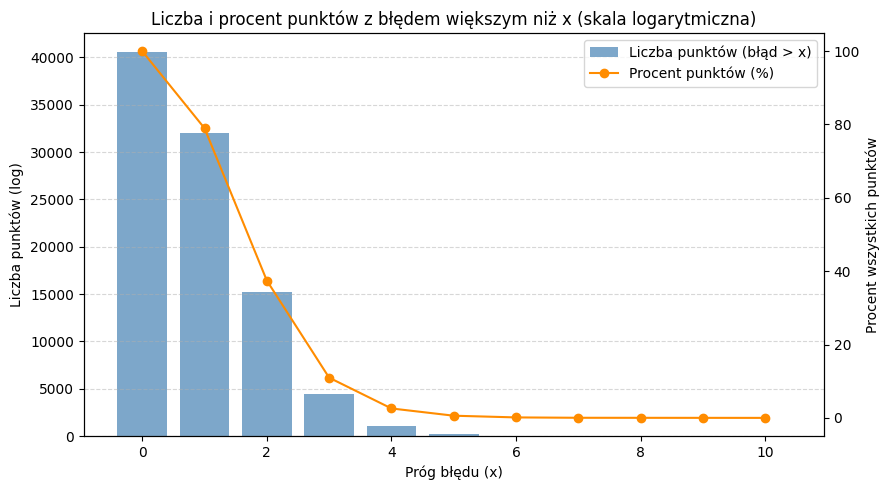

In [81]:
import numpy as np
import matplotlib.pyplot as plt

# Zakładamy, że masz już tablicę errors o shape (n_samples, 19)
# errors = np.linalg.norm(predicted - original, axis=2)

flat_errors = errors.flatten()

# Maksymalny błąd (zaokrąglony w górę)
# m = int(np.ceil(flat_errors.max()))
m = 10

# Progi od 0 do m
x_values = np.arange(0, m + 1)

# Liczba i procent punktów z błędem > x
counts = [np.sum(flat_errors > x) for x in x_values]
percentages = [100 * c / len(flat_errors) for c in counts]

# Tworzymy wykres
fig, ax1 = plt.subplots(figsize=(9, 5))

# Kolumny - liczba punktów (log scale)
ax1.bar(x_values, counts, color='steelblue', alpha=0.7, label='Liczba punktów (błąd > x)')
ax1.set_xlabel('Próg błędu (x)')
ax1.set_ylabel('Liczba punktów (log)')
# ax1.set_yscale('log')  # <<<<<< LOGARYTMICZNA SKALA
ax1.grid(True, which="both", axis='y', linestyle='--', alpha=0.5)
ax1.set_title('Liczba i procent punktów z błędem większym niż x (skala logarytmiczna)')

# Druga oś - procent punktów
ax2 = ax1.twinx()
ax2.plot(x_values, percentages, color='darkorange', marker='o', label='Procent punktów (%)')
ax2.set_ylabel('Procent wszystkich punktów')

# Legenda łączona
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

plt.tight_layout()
plt.show()
